## Loading of amygdala data

includes some visualizations

### Imports

In [1]:
import pathlib
from collections import defaultdict

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Figure Settings

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

### Data files

In [3]:
data_path = pathlib.Path("../data/amygdala")
files_mat = list(data_path.rglob('*h5'))
files_mat

[PosixPath('../data/amygdala/data_NIX/Data_Subject_08_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_03_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_05_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_07_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_04_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_01_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_02_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_06_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_09_Session_01.h5')]

### Load data for one trial

In [4]:
f_mat = files_mat[5]
with h5py.File(f_mat, "r") as f:
    spike_times = np.array(
        f["data"]["Data_Subject_01_Session_01"]["data_arrays"][
            "Spike_Times_Unit_1_uAL_1_Trial_14"
        ]["data"]
    )
    lfp = np.array(
        f["data"]["Data_Subject_01_Session_01"]["data_arrays"]["iEEG_Data_Trial_14"][
            "data"
        ]
    )
    conditions = list(f['data']['Data_Subject_01_Session_01']['tags'].keys())
    labels = []
    print(conditions)
    for cond in conditions[: int(len(conditions) / 2)]:
        labels.append(cond.split('Condition_')[1].split('_Trial')[0].split('_')[1])

print(labels)
le = LabelEncoder()
labels = le.fit_transform(labels)
print('Labels: ', labels)

['Stimulus_Condition_1_Neutral_Trial_01_iEEG', 'Stimulus_Condition_2_Aversive_Trial_02_iEEG', 'Stimulus_Condition_1_Neutral_Trial_03_iEEG', 'Stimulus_Condition_2_Aversive_Trial_04_iEEG', 'Stimulus_Condition_1_Neutral_Trial_05_iEEG', 'Stimulus_Condition_2_Aversive_Trial_06_iEEG', 'Stimulus_Condition_1_Neutral_Trial_07_iEEG', 'Stimulus_Condition_2_Aversive_Trial_08_iEEG', 'Stimulus_Condition_1_Neutral_Trial_09_iEEG', 'Stimulus_Condition_2_Aversive_Trial_10_iEEG', 'Stimulus_Condition_1_Neutral_Trial_11_iEEG', 'Stimulus_Condition_2_Aversive_Trial_12_iEEG', 'Stimulus_Condition_1_Neutral_Trial_13_iEEG', 'Stimulus_Condition_2_Aversive_Trial_14_iEEG', 'Stimulus_Condition_1_Neutral_Trial_15_iEEG', 'Stimulus_Condition_2_Aversive_Trial_16_iEEG', 'Stimulus_Condition_1_Neutral_Trial_17_iEEG', 'Stimulus_Condition_1_Neutral_Trial_01_Spike_Times', 'Stimulus_Condition_2_Aversive_Trial_02_Spike_Times', 'Stimulus_Condition_1_Neutral_Trial_03_Spike_Times', 'Stimulus_Condition_2_Aversive_Trial_04_Spike_Tim

### Trial time

In [5]:
fs = 2000
# time = np.linspace(0, 24, lfp.shape[-1])
time = np.arange(lfp.shape[-1]) / fs - 2
time

array([-2.    , -1.9995, -1.999 , ..., 23.9985, 23.999 , 23.9995])

### Sanity check (ISIs should be larger than 2s)

In [6]:
min_isi = np.diff(spike_times).min()
min_isi

0.0058437500000003695

### Visualize spikes wrt LFP

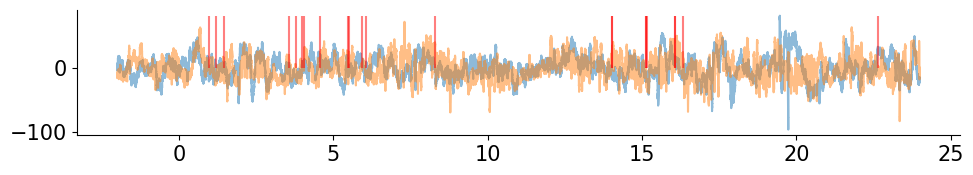

In [28]:
plt.figure(figsize=(10, 2))
plt.plot(time, lfp.T, alpha=0.5)
plt.vlines(spike_times, 0, lfp.max(), "r", alpha=0.5)
plt.show()

### Function to crop a prespike window

In [29]:
def crop_prespike_window(lfp, t_spike, time, window_size, channel):
    in_window = (time < t_spike) & (time > t_spike - window_size)
    return lfp[channel, in_window]


def to_sample_idx(t_spike, time):
    return np.argmin((t_spike - time) ** 2)


def crop_prespike_window(lfp, idx_spike, window_size, channel):
    return lfp[channel, idx_spike - window_size : idx_spike]



### Plot spike triggered LFP

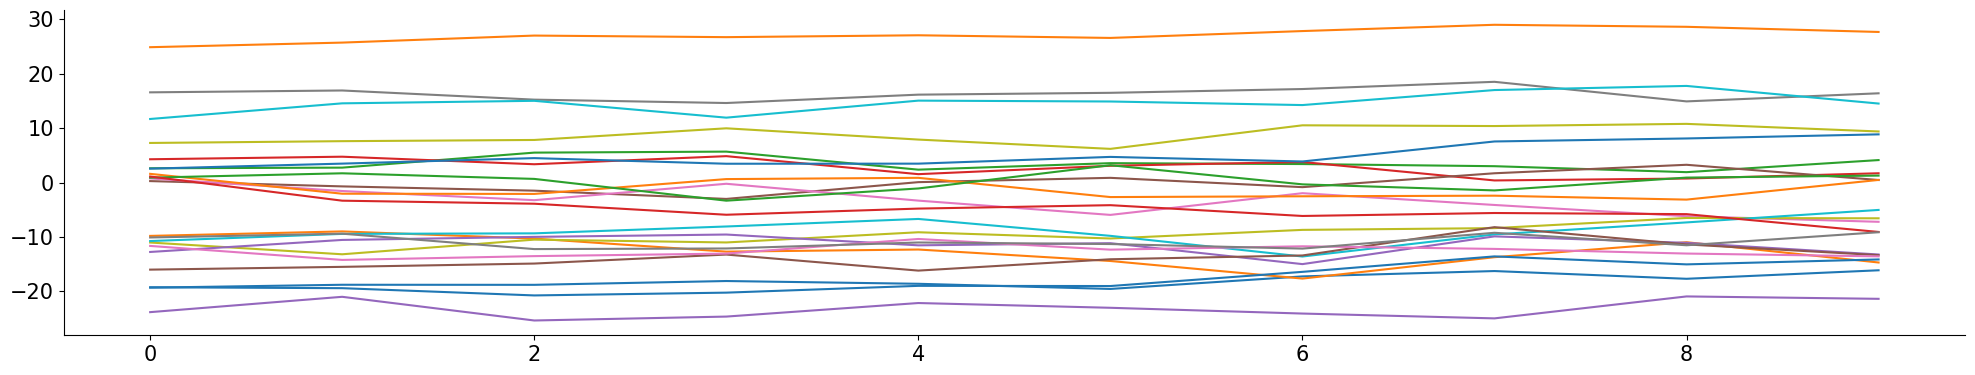

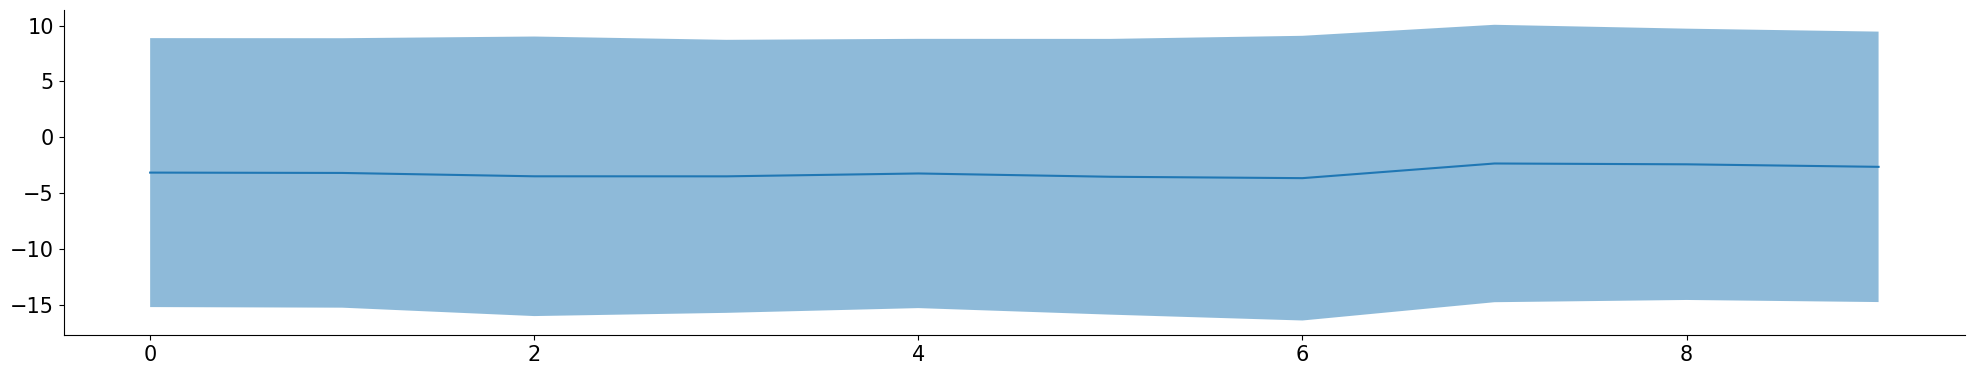

In [30]:
window_size = 10
channel_idx = 0

prespike_lfps = []
for t_spike in spike_times:
    idx_spike = to_sample_idx(t_spike, time)
    prespike_lfps.append(crop_prespike_window(lfp, idx_spike, window_size, channel_idx))
prespike_lfps = np.stack(prespike_lfps)

plt.plot(prespike_lfps.T)
plt.show()

st_avg_lfp = prespike_lfps.mean(0)
st_var_lfp = prespike_lfps.std(0)

plt.plot(st_avg_lfp.T)
plt.fill_between(
    range(window_size), st_avg_lfp + st_var_lfp, st_avg_lfp - st_var_lfp, alpha=0.5
)
plt.show()

### Extract data for a unit

In [44]:
window_size = 20
channel_idx = 0

unit = 1
spike_times_id = f"Spike_Times_Unit_{unit}_"

spike_times_ds = []
lfp_ds = []
labels_ds = []

label_id = {'neutral': 0, 'aversive': 1}

for f_mat in files_mat:
    session = f_mat.stem
    with h5py.File(f_mat, "r") as f:
        conditions = list(f['data'][session]['tags'].keys())
        for key in f["data"][session]["data_arrays"].keys():
            # only extract spike times for a relevant unit
            if spike_times_id in key:
                # provide a key matching the trial for a relevant unit
                trial_id = key.split("_")[-1]
                trial_key = f"iEEG_Data_Trial_{trial_id}"

                # extract spike times and lfp of the current trial
                spike_times = torch.tensor(
                    np.array(f["data"][session]["data_arrays"][key]["data"])
                )
                lfp = torch.tensor(
                    np.array(f["data"][session]["data_arrays"][trial_key]["data"])
                )
                # collect spike times and lfps
                spike_times_ds.append(spike_times)
                lfp_ds.append(lfp)
                for cond in conditions[: int(len(conditions) / 2)]:
                    cond = cond.lower()
                    if trial_id in cond:
                        if 'neutral' in cond:
                            labels_ds.append(label_id['neutral'])
                        else:
                            labels_ds.append(label_id['aversive'])

### Train / Test split

In [43]:
def make_dataset(spike_times_ds, lfp_ds, labels_ds, window_size, control=False):
    y = []
    X = defaultdict(list)
    for spike_times, lfp, label in zip(spike_times_ds, lfp_ds, labels_ds):
        # handle single channels
        if lfp.dim() < 2:
            lfp = lfp.unsqueeze(0)
        if control:
            spike_times = torch.randint(0, lfp.shape[-1], size=(len(spike_times), 1))
        for t_spike in spike_times:
            idx_spike = to_sample_idx(t_spike, time)
            lfp_crop = crop_prespike_window(lfp, idx_spike, window_size, channel_idx)
            if len(lfp_crop) == window_size:
                X["time"].append(idx_spike.item())
                X["lfp_crop"].append(lfp_crop.numpy())
                y.append(label)
    return X["lfp_crop"], y

In [44]:
n_runs = 10
acc_control = []
acc_prespike = []


for _ in range(n_runs):

    n_train = int(0.6*len(spike_times_ds))
    permutation = torch.randperm(len(labels_ds))

    spike_times_train_ds = [spike_times_ds[idx] for idx in permutation[:n_train]]
    lfp_train_ds = [lfp_ds[idx] for idx in permutation[:n_train]]
    labels_train_ds = [labels_ds[idx] for idx in permutation[:n_train]]

    spike_times_val_ds = [spike_times_ds[idx] for idx in permutation[n_train:]]
    lfp_val_ds = [lfp_ds[idx] for idx in permutation[n_train:]]
    labels_val_ds = [labels_ds[idx] for idx in permutation[n_train:]]

    X_control_train, y_control_train = make_dataset(spike_times_train_ds, lfp_train_ds, labels_train_ds, window_size, control=True)
    X_control_val, y_control_val = make_dataset(spike_times_val_ds, lfp_val_ds, labels_val_ds, window_size, control=True)

    X_prespike_train, y_prespike_train = make_dataset(spike_times_train_ds, lfp_train_ds, labels_train_ds, window_size)
    X_prespike_val, y_prespike_val = make_dataset(spike_times_val_ds, lfp_val_ds, labels_val_ds, window_size)

    clf = make_pipeline(StandardScaler(), RandomForestClassifier())
    clf.fit(X_control_train, y_control_train)
    accuracy_control = 100*clf.score(X_control_val, y_control_val)
    print(f"Control - Accuracy: {accuracy_control:.3} %")

    clf = make_pipeline(StandardScaler(), RandomForestClassifier())
    clf.fit(X_prespike_train, y_prespike_train)
    accuracy_prespike = 100*clf.score(X_prespike_val, y_prespike_val)
    print(f"Prespike - Accuracy: {accuracy_prespike:.3} %")

    acc_control.append(accuracy_control)
    acc_prespike.append(accuracy_prespike)

Control - Accuracy: 67.7 %
Prespike - Accuracy: 50.8 %
Control - Accuracy: 76.4 %
Prespike - Accuracy: 46.7 %
Control - Accuracy: 56.6 %
Prespike - Accuracy: 42.6 %
Control - Accuracy: 73.9 %
Prespike - Accuracy: 48.0 %
Control - Accuracy: 48.3 %
Prespike - Accuracy: 42.7 %
Control - Accuracy: 52.8 %
Prespike - Accuracy: 51.0 %
Control - Accuracy: 45.4 %
Prespike - Accuracy: 48.3 %
Control - Accuracy: 51.3 %
Prespike - Accuracy: 50.2 %
Control - Accuracy: 81.5 %
Prespike - Accuracy: 44.7 %
Control - Accuracy: 27.6 %
Prespike - Accuracy: 52.0 %


In [ ]:
plt.hist(acc_control, "r", alpha=0.3)
plt.hist(acc_prespike, "b", alpha=0.3)
plt.show()